In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
import sys,os 

os.chdir("..")
os.chdir("python scripts")

from particle_class import particle
from amplitude_class import amplitude
from process_class import process
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.integrate import ode

%matplotlib inline

# The Particle Class 

In [2]:
pion = particle(1, 0, 5, 0.1)
alp = particle(0.5, 0, 1, 0.1)
photon = particle(0, 1, 2, 0.1)

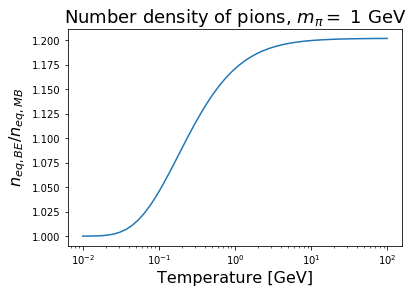

In [3]:
neqlist=[]
approxlist=[]
fastpion = particle(1, 0, 5, 0.1, fast=True)
for i in np.logspace(-1, 2):
    pion.update(i)
    fastpion.update(i)
    neqlist.append(pion.neq())
    approxlist.append(fastpion.neq())
plt.semilogx(np.logspace(-2, 2), np.array(neqlist)/np.array(approxlist))
plt.gca()
plt.xlabel('Temperature [GeV]', fontsize=16)
plt.ylabel(r'$n_{eq, BE}/n_{eq, MB}$', fontsize=16)
plt.ticklabel_format(fontsize=18)
plt.title('Number density of pions, $m_\pi =$ 1 GeV', fontsize=18)


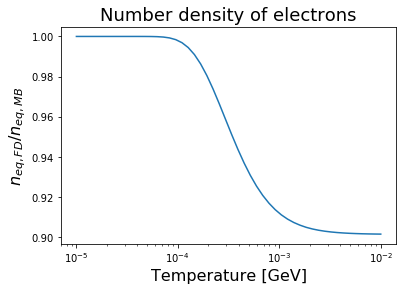

In [4]:
approxlist=[] 
flist=[]
fastelectron = particle(5e-4, 0.5, 2, 0.1, fast=True)
electron = particle(5e-4, 0.5, 2, 0.1)
for i in np.logspace(-5, -2):
    fastelectron.update(i), electron.update(i)
    approxlist.append(fastelectron.neq()), flist.append(electron.neq())

plt.semilogx(np.logspace(-5, -2), np.array(flist)/np.array(approxlist))
plt.gca()
plt.xlabel('Temperature [GeV]', fontsize=16)
plt.ylabel(r'$n_{eq, FD}/n_{eq, MB}$', fontsize=16)
plt.ticklabel_format(fontsize=18)
plt.title('Number density of electrons', fontsize=18)

# The Amplitude and Process Classes

In [4]:
fourpt = amplitude(lambda s:1e-10, s=True)
alpPhotons = amplitude(lambda s: alp.mass**4*4e-10,threept=True)

In [5]:
annihilation=process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp,nevals=3e4)
antiannihilation = process(fourpt, i1=alp, i2=alp, f1=pion, f2=pion,nevals=3e4)
transfer = process(fourpt, i1=pion,i2=alp,f1=pion,f2=alp,nonequilibrium=True)
decaytophotons = process(alpPhotons, i1=alp,f1=photon,f2=photon, nevals=3e3, Ecut=50)
photoninversedecay = process(alpPhotons, i1=photon,i2=photon,f1=alp, nevals=3e3)

annihilation_check=process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp, analytic=True)
antiannihilation_check = process(fourpt, i1=alp, i2=alp, f1=pion, f2=pion, analytic=True)
transfer_check = process(fourpt, i1=pion,i2=alp,f1=pion,f2=alp,nonequilibrium=True,  analytic=True)
decaytophotons_check = process(alpPhotons, i1=alp,f1=photon,f2=photon,  analytic=True)
photoninversedecay_check = process(alpPhotons, i1=photon,i2=photon,f1=alp, analytic=True)

In [6]:
tempscan = np.logspace(1, -2., 31)
MBalp = particle(0.5, 0, 1, 0.1, fast=True)

alp.mass_update(0.5)
MBalp.mass_update(0.5)
xsection=[]
approxxsection = []
for i in tempscan:
    alp.update(i)
    photon.update(i)
    MBalp.update(i)
    xsection.append(decaytophotons.CrossSection().val/alp.neq())
    approxxsection.append(1e-10*decaytophotons_check.CrossSection()/MBalp.neq())
    
alp.mass_update(0.1)
MBalp.mass_update(0.1)
xsection2=[]
approxxsection2 = []
for i in tempscan:
    alp.update(i)
    photon.update(i)
    MBalp.update(i)
    xsection2.append(3e-1*decaytophotons.CrossSection().val/alp.neq())
    approxxsection2.append(3e-11*decaytophotons_check.CrossSection()/MBalp.neq())

NameError: name 's' is not defined

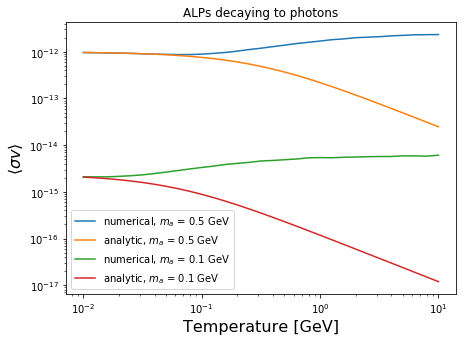

In [8]:
f, ax = plt.subplots()

ax.loglog(tempscan, xsection,label='numerical, $m_a$ = 0.5 GeV')
ax.loglog(tempscan, approxxsection,label='analytic, $m_a$ = 0.5 GeV')
ax.loglog(tempscan, xsection2,label='numerical, $m_a$ = 0.1 GeV')
ax.loglog(tempscan, approxxsection2, label='analytic, $m_a$ = 0.1 GeV')

ax.set_xlabel('Temperature [GeV]', fontsize=16)
ax.set_ylabel(r'$\left< \sigma v \right>$', fontsize=16)
ax.set_title('ALPs decaying to photons')
ax.legend()
f.set_size_inches(7,5)


In [9]:
#check convergence at higher temperatures
highres_decay = process(alpPhotons, i1=alp,f1=photon,f2=photon, nevals=1e4)
higherres_decay = process(alpPhotons, i1=alp,f1=photon,f2=photon, nevals=3e4)

In [10]:
alp.update(10)
photon.update(10)
result =decaytophotons.CrossSection()
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
result =highres_decay.CrossSection()
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
result =higherres_decay.CrossSection()
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
print('ANALYTIC PREDICTION = ', 1e-10*decaytophotons_check.CrossSection())

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.321(77)e-12   2.321(77)e-12       0.00     1.00
  2   2.345(72)e-12   2.334(53)e-12       0.05     0.82
  3   2.49(14)e-12    2.352(49)e-12       0.53     0.59
  4   2.325(46)e-12   2.338(34)e-12       0.41     0.75
  5   2.51(11)e-12    2.352(32)e-12       0.85     0.49
  6   2.322(45)e-12   2.342(26)e-12       0.74     0.59
  7   2.496(74)e-12   2.359(25)e-12       1.25     0.28
  8   2.528(91)e-12   2.371(24)e-12       1.53     0.15
  9   2.396(63)e-12   2.374(22)e-12       1.36     0.21
 10   2.374(62)e-12   2.374(21)e-12       1.21     0.28

result = 2.374(21)e-12    Q = 0.28
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   1.4711(53)e-12  1.4711(53)e-12      0.00     1.00
  2   1.4715(54)e-12  1.4712(38)e-12      0.00     0.96
  3   1.4702(54)e-12  1.4709(31)e-12      0.01     0.99
  4   1.4669

In [11]:
#check convergence in energy cut for integral
decaytophotons_highE = process(alpPhotons, i1=alp,f1=photon,f2=photon, nevals=1e4, Ecut=10)
decaytophotons_higherE = process(alpPhotons, i1=alp,f1=photon,f2=photon, nevals=1e4, Ecut=20)

In [12]:
alp.update(10)
photon.update(10)
result =decaytophotons_highE.CrossSection()
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))
result =decaytophotons_higherE.CrossSection()
print(result.summary())
print('result = %s    Q = %.2f' % (result, result.Q))

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   3.6(1.2)e-12    3.6(1.2)e-12        0.00     1.00
  2   2.298(35)e-12   2.299(35)e-12       1.25     0.26
  3   2.459(96)e-12   2.318(32)e-12       1.85     0.16
  4   2.337(35)e-12   2.327(24)e-12       1.28     0.28
  5   2.516(65)e-12   2.349(22)e-12       2.85     0.02
  6   2.57(11)e-12    2.358(22)e-12       3.07     0.01
  7   2.425(42)e-12   2.372(19)e-12       2.90     0.01
  8   2.354(39)e-12   2.369(17)e-12       2.51     0.01
  9   2.373(29)e-12   2.370(15)e-12       2.20     0.02
 10   2.51(11)e-12    2.373(15)e-12       2.14     0.02

result = 2.373(15)e-12    Q = 0.02
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.44(11)e-12    2.44(11)e-12        0.00     1.00
  2   2.466(94)e-12   2.455(71)e-12       0.04     0.85
  3   2.65(33)e-12    2.463(69)e-12       0.18     0.83
  4   2.473(

In [13]:
tempscan = np.logspace(1, -1.5, 10)
MBpion = particle(1, 0, 5, 0.1, fast=True)

alp.mass_update(0.5)
pion.mass_update(1), MBpion.mass_update(1)
xsection=[]
approxxsection = []
for i in tempscan:
    alp.update(i)
    pion.update(i), MBpion.update(i)
    xsection.append(annihilation.CrossSection().val/pion.neq()**2)
    approxxsection.append(1e-10*annihilation_check.CrossSection()/MBpion.neq()**2)
    
alp.mass_update(0.2)
pion.mass_update(0.7),MBpion.mass_update(0.7)
xsection2=[]
approxxsection2 = []
for i in tempscan:
    alp.update(i)
    pion.update(i),MBpion.update(i)
    xsection2.append(3e-1*annihilation.CrossSection().val/pion.neq()**2)
    approxxsection2.append(3e-11*annihilation_check.CrossSection()/MBpion.neq()**2)

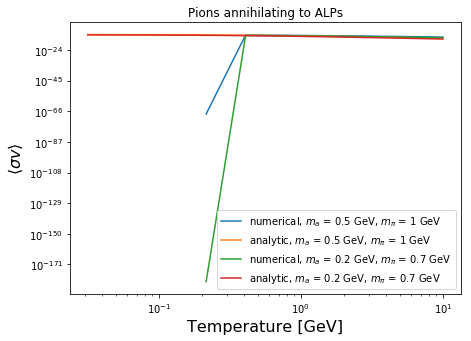

In [14]:
f, ax = plt.subplots()

ax.loglog(tempscan, 0.0335*np.array(xsection),label='numerical, $m_a$ = 0.5 GeV, $m_\pi$ = 1 GeV')
ax.loglog(tempscan, approxxsection,label='analytic, $m_a$ = 0.5 GeV, $m_\pi$ = 1 GeV')
ax.loglog(tempscan, 0.0335*np.array(xsection2),label='numerical, $m_a$ = 0.2 GeV, $m_\pi$ = 0.7 GeV')
ax.loglog(tempscan, approxxsection2, label='analytic, $m_a$ = 0.2 GeV, $m_\pi$ = 0.7 GeV')

ax.set_xlabel('Temperature [GeV]', fontsize=16)
ax.set_ylabel(r'$\left< \sigma v \right>$', fontsize=16)
ax.set_title('Pions annihilating to ALPs')
#ax.set_xlim(0.41, 10)
#ax.set_ylim(1e-17, 2e-12)
ax.legend()
f.set_size_inches(7,5)

In [15]:
#check convergence at higher temperatures
highres_annihilation = process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp, nevals=6e4)
higherres_ann = process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp, nevals=1e5)
pion.update(10)
alp.update(10)
print(annihilation.CrossSection())
print(highres_annihilation.CrossSection())
print(higherres_ann.CrossSection())
print(1e-10*annihilation_check.CrossSection()/0.0335)

8.757(38)e-09
1.4202(19)e-09
1.4202(14)e-09
7.485080231741217e-10


In [16]:
#check convergence at higher temperatures
highE_annihilation = process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp, Ecut=10)
higherE_ann = process(fourpt, i1=pion,i2=pion,f1=alp,f2=alp, Ecut=20)
pion.update(10)
alp.update(10)
print(annihilation.CrossSection())
print(highE_annihilation.CrossSection())
print(higherE_ann.CrossSection())
print(1e-10*annihilation_check.CrossSection()/0.0335)

8.791(36)e-09
8.639(76)e-09
8.680(81)e-09
7.485080231741217e-10


In [17]:
electron = particle(5e-4, 1/2, 2, 0.1)
alpElectrons = amplitude(lambda s: 2*alp.mass**2*electron.mass**2,threept=True)
decaytoelectrons = process(alpElectrons, i1=alp,f1=electron,f2=electron, nevals=3e3)
decaytoelectrons_check = process(alpElectrons, i1=alp,f1=electron,f2=electron, analytic=True)

In [18]:
tempscan = np.logspace(1, -2, 30)
MBalp = particle(0.5, 0, 1, 0.1, fast=True)

alp.mass_update(1), MBalp.mass_update(1)
xsection=[]
approxxsection = []
for i in tempscan:
    alp.update(i),MBalp.update(i)
    electron.update(i)
    xsection.append(decaytoelectrons.CrossSection().val/alp.neq())
    approxxsection.append(decaytoelectrons_check.CrossSection()/MBalp.neq())
    
alp.mass_update(0.1),MBalp.mass_update(0.1)
xsection2=[]
approxxsection2 = []
for i in tempscan:
    alp.update(i), MBalp.update(i)
    electron.update(i)
    xsection2.append(decaytoelectrons.CrossSection().val/alp.neq())
    approxxsection2.append(decaytoelectrons_check.CrossSection()/MBalp.neq())

alp.mass_update(0.3),MBalp.mass_update(0.3)
xsection3=[]
approxxsection3 = []
for i in tempscan:
    alp.update(i), MBalp.update(i)
    electron.update(i)
    xsection3.append(decaytoelectrons.CrossSection().val/alp.neq())
    approxxsection3.append(decaytoelectrons_check.CrossSection()/MBalp.neq())

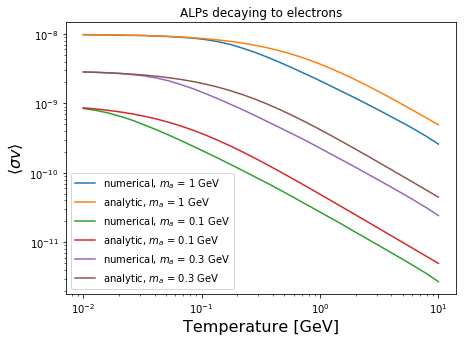

In [19]:
f, ax = plt.subplots()

ax.loglog(tempscan, xsection,label='numerical, $m_a$ = 1 GeV')
ax.loglog(tempscan, approxxsection,label='analytic, $m_a$ = 1 GeV')
ax.loglog(tempscan, np.array(xsection2),label='numerical, $m_a$ = 0.1 GeV')
ax.loglog(tempscan, np.array(approxxsection2), label='analytic, $m_a$ = 0.1 GeV')
ax.loglog(tempscan, np.array(xsection3),label='numerical, $m_a$ = 0.3 GeV')
ax.loglog(tempscan, np.array(approxxsection3), label='analytic, $m_a$ = 0.3 GeV')

ax.set_xlabel('Temperature [GeV]', fontsize=16)
ax.set_ylabel(r'$\left< \sigma v \right>$', fontsize=16)
ax.set_title('ALPs decaying to electrons')
ax.legend()
f.set_size_inches(7,5)

In [20]:
tempscan = np.logspace(1, -2, 30)
MBalp = particle(0.5, 0, 1, 0.1, fast=True)
MBpion = particle(1, 0, 5, 0.1, fast=True)

alp.mass_update(0.3), MBalp.mass_update(0.3)
electron.update(0.1)
xsection=[]
approxxsection = []
for i in tempscan:
    alp.update(i),MBalp.update(i)
    #electron.update(i)
    xsection.append(decaytoelectrons.CrossSection().val/alp.neq())
    approxxsection.append(decaytoelectrons_check.CrossSection()/MBalp.neq())
    
tempscan = np.logspace(1, -2, 10)
alp.mass_update(0.5)
alp.update(1)
pion.mass_update(1), MBpion.mass_update(1)
xsection2=[]
approxxsection2 = []
for i in tempscan:
    #alp.update(i)
    pion.update(i), MBpion.update(i)
    xsection2.append(annihilation.CrossSection().val/pion.neq()**2)
    approxxsection2.append(1e-10*annihilation_check.CrossSection()/MBpion.neq()**2)
    
tempscan = np.logspace(1, -2, 30)
alp.mass_update(0.5), MBalp.mass_update(0.5)
photon.update(1)
xsection3=[]
approxxsection3 = []
for i in tempscan:
    alp.update(i)
    #photon.update(i)
    MBalp.update(i)
    xsection3.append(decaytophotons.CrossSection().val/alp.neq())
    approxxsection3.append(1e-10*decaytophotons_check.CrossSection()/MBalp.neq())

In [21]:
tempscan = np.logspace(1, -2, 30)
alp.mass_update(0.5), MBalp.mass_update(0.5)
photon.update(1)
xsection3=[]
approxxsection3 = []
for i in tempscan:
    alp.update(i)
    #photon.update(i)
    MBalp.update(i)
    xsection3.append(decaytophotons.CrossSection().val/alp.neq())
    approxxsection3.append(1e-10*decaytophotons_check.CrossSection()/MBalp.neq())

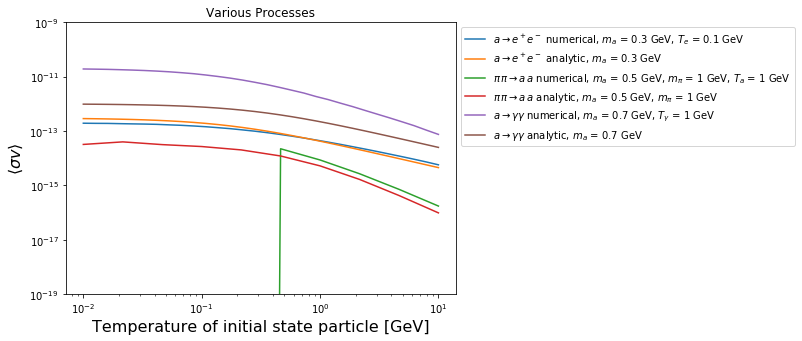

In [57]:
f, ax = plt.subplots()

ax.loglog(tempscan, 1e-4*np.array(xsection),label=r'$a\rightarrow e^+ e^-$ numerical, $m_a$ = 0.3 GeV, $T_e$ = 0.1 GeV')
ax.loglog(tempscan, 1e-4*np.array(approxxsection),label=r'$a\rightarrow e^+ e^-$ analytic, $m_a$ = 0.3 GeV')
ax.loglog(np.logspace(1, -2, 10), 0.0335*np.array(xsection2),label=r'$\pi\, \pi \rightarrow a \,a$ numerical, $m_a$ = 0.5 GeV, $m_\pi$ = 1 GeV, $T_a$ = 1 GeV')
ax.loglog(np.logspace(1, -2, 10), np.array(approxxsection2), label=r'$\pi \,\pi\rightarrow a \,a$ analytic, $m_a$ = 0.5 GeV, $m_\pi$ = 1 GeV')
ax.loglog(tempscan, np.array(xsection3),label=r'$a\rightarrow \gamma \gamma$ numerical, $m_a$ = 0.7 GeV, $T_\gamma$ = 1 GeV')
ax.loglog(tempscan, np.array(approxxsection3), label=r'$a\rightarrow \gamma \gamma$ analytic, $m_a$ = 0.7 GeV')

ax.set_xlabel('Temperature of initial state particle [GeV]', fontsize=16)
ax.set_ylabel(r'$\left< \sigma v \right>$', fontsize=16)
ax.set_title('Various Processes')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylim(10E-20,10E-10)
f.set_size_inches(7,5)
